# CHAPTER 8

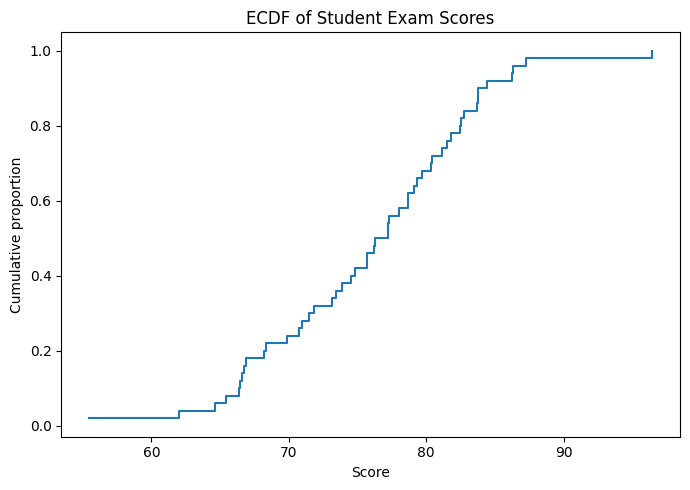

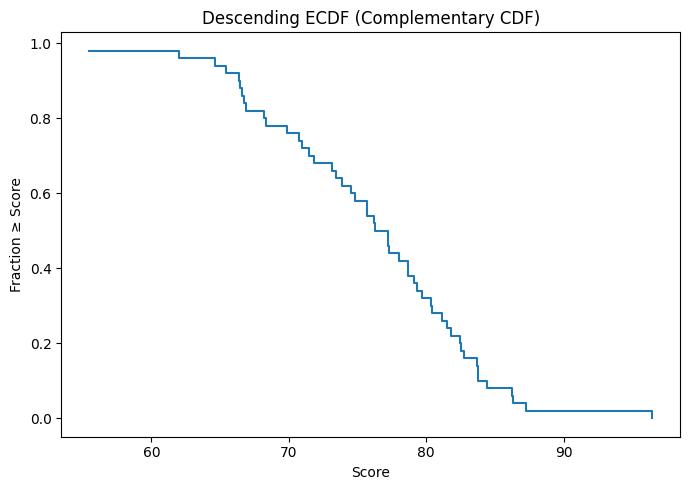

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(42)

# ----------------------------------------------------------
# Dataset setup
# ----------------------------------------------------------
scores = rng.normal(75, 10, 50)          # Exam scores ~ Normal
scores = np.clip(scores, 0, 100)

population = np.exp(rng.normal(10, 1.2, 3000))   # Right-skewed (log-normal)
word_counts = np.random.zipf(a=2.0, size=5000)   # Very heavy tail

# ----------------------------------------------------------
# 8.1 Empirical Cumulative Distribution Function (ECDF)
# ----------------------------------------------------------
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_scores, y_scores = ecdf(scores)

plt.figure(figsize=(7,5))
plt.step(x_scores, y_scores, where='post')
plt.xlabel("Score")
plt.ylabel("Cumulative proportion")
plt.title("ECDF of Student Exam Scores")
plt.tight_layout()
plt.show()

# Descending ECDF
plt.figure(figsize=(7,5))
plt.step(x_scores, 1 - y_scores, where='post')
plt.xlabel("Score")
plt.ylabel("Fraction ≥ Score")
plt.title("Descending ECDF (Complementary CDF)")
plt.tight_layout()
plt.show()


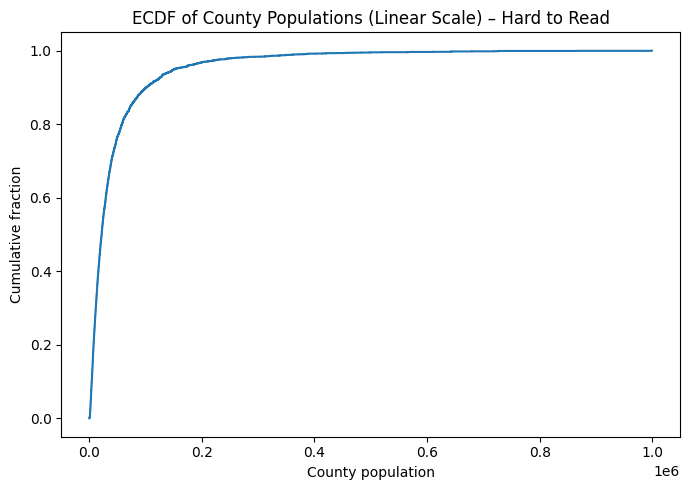

In [2]:
# 8.2 Highly Skewed Distributions
# ----------------------------------------------------------
# (a) Linear scale – misleading
x_pop, y_pop = ecdf(population)
plt.figure(figsize=(7,5))
plt.step(x_pop, y_pop, where='post')
plt.xlabel("County population")
plt.ylabel("Cumulative fraction")
plt.title("ECDF of County Populations (Linear Scale) – Hard to Read")
plt.tight_layout()
plt.show()

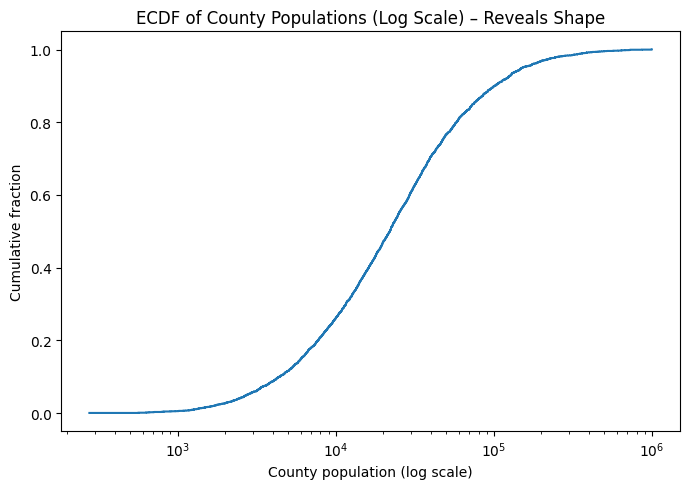

In [3]:
# (b) Log scale – reveals structure
plt.figure(figsize=(7,5))
plt.step(x_pop, y_pop, where='post')
plt.xscale("log")
plt.xlabel("County population (log scale)")
plt.ylabel("Cumulative fraction")
plt.title("ECDF of County Populations (Log Scale) – Reveals Shape")
plt.tight_layout()
plt.show()


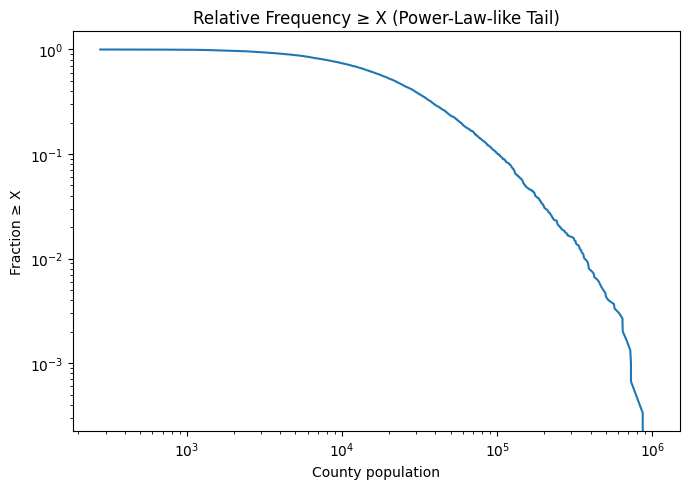

In [4]:
# (c) Relative frequency ≥ X (like Fig. 8.6–8.7)
plt.figure(figsize=(7,5))
counts = np.sort(population)
rel_freq = 1 - np.arange(1, len(counts)+1) / len(counts)
plt.loglog(counts, rel_freq)
plt.xlabel("County population")
plt.ylabel("Fraction ≥ X")
plt.title("Relative Frequency ≥ X (Power-Law-like Tail)")
plt.tight_layout()
plt.show()

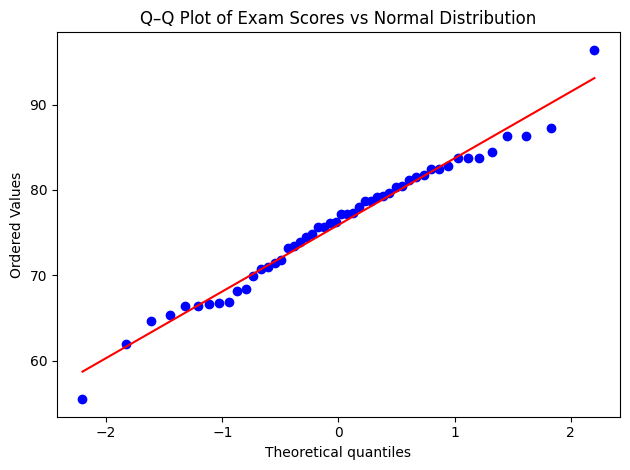

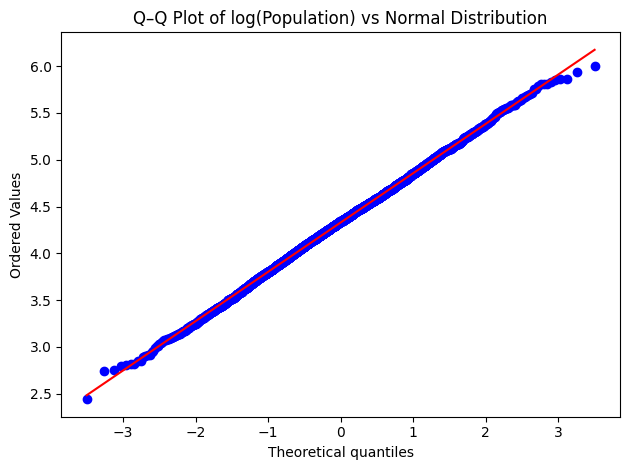

In [5]:
# 8.3 Quantile–Quantile (Q–Q) Plots
# ----------------------------------------------------------
# (a) Q–Q plot of exam scores vs Normal distribution
stats.probplot(scores, dist="norm", plot=plt)
plt.title("Q–Q Plot of Exam Scores vs Normal Distribution")
plt.tight_layout()
plt.show()

# (b) Q–Q plot of log(population) vs Normal
log_pop = np.log10(population)
stats.probplot(log_pop, dist="norm", plot=plt)
plt.title("Q–Q Plot of log(Population) vs Normal Distribution")
plt.tight_layout()
plt.show()

# CHAPTER 9

In [6]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
rng = np.random.default_rng(0)

months = np.arange(1,13)
city_params = {
    "Los Angeles": (65, 5),
    "Chicago":     (55,15),
    "Denver":      (52,12),
    "Miami":       (80, 5),
}
records=[]
for city,(mean,sd) in city_params.items():
    for m in months:
        # mild seasonal sinusoid + noise
        shift = 10*np.sin((m-1)/12*2*np.pi)
        vals = rng.normal(mean+shift, sd, size=30)
        for v in vals: records.append((city,m,v))
df = pd.DataFrame(records, columns=["City","Month","Temp"])


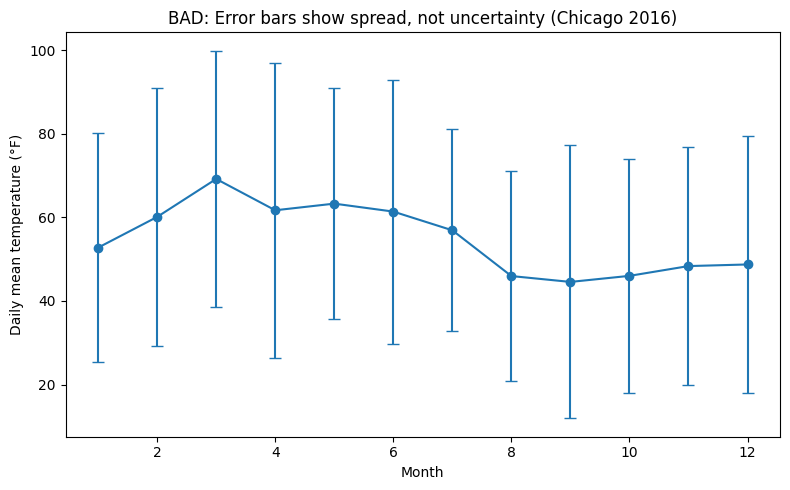

In [7]:
means = df.groupby(["City","Month"])["Temp"].mean().unstack()
stds  = df.groupby(["City","Month"])["Temp"].std().unstack()

plt.figure(figsize=(8,5))
plt.errorbar(months, means.loc["Chicago"], yerr=2*stds.loc["Chicago"],
             fmt='o-', capsize=4)
plt.title("BAD: Error bars show spread, not uncertainty (Chicago 2016)")
plt.xlabel("Month"); plt.ylabel("Daily mean temperature (°F)")
plt.tight_layout(); plt.show()


<Figure size 900x500 with 0 Axes>

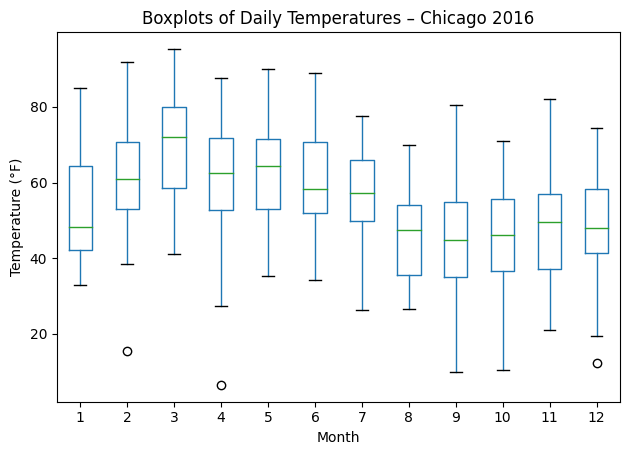

In [8]:
plt.figure(figsize=(9,5))
df_chi=df[df.City=="Chicago"]
df_chi.boxplot(column="Temp", by="Month", grid=False)
plt.suptitle("")
plt.title("Boxplots of Daily Temperatures – Chicago 2016")
plt.xlabel("Month"); plt.ylabel("Temperature (°F)")
plt.tight_layout(); plt.show()


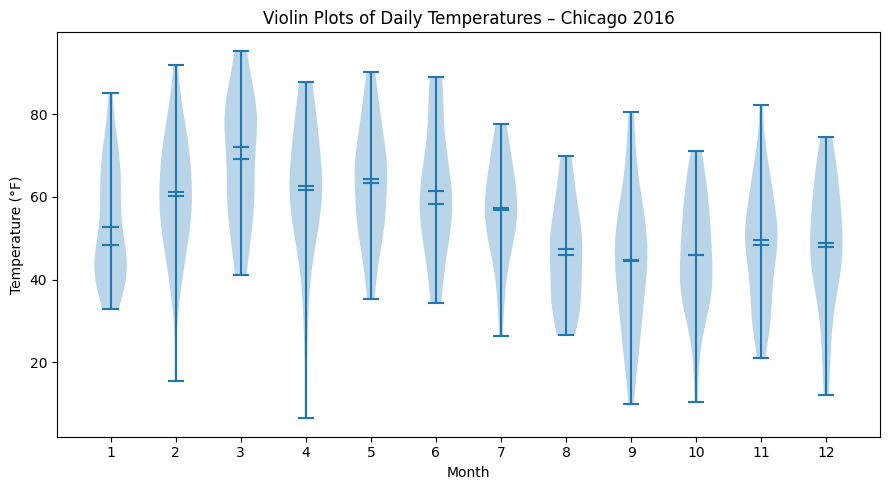

In [9]:
plt.figure(figsize=(9,5))
plt.violinplot([df_chi[df_chi.Month==m].Temp for m in months],
               showmeans=True, showextrema=True, showmedians=True)
plt.title("Violin Plots of Daily Temperatures – Chicago 2016")
plt.xlabel("Month"); plt.ylabel("Temperature (°F)")
plt.xticks(range(1,13)); plt.tight_layout(); plt.show()


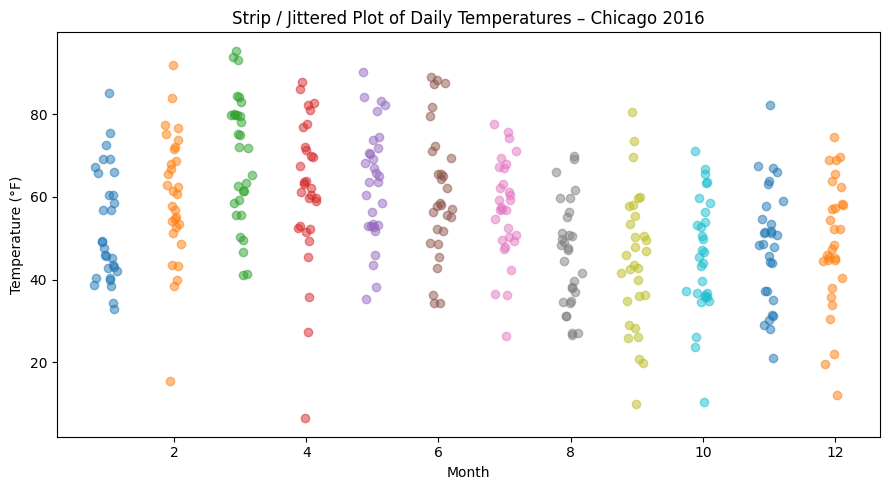

In [10]:
plt.figure(figsize=(9,5))
for i,m in enumerate(months):
    vals=df_chi[df_chi.Month==m].Temp
    jitter = rng.normal(0,0.08,len(vals))
    plt.scatter(np.full(len(vals),m)+jitter, vals, alpha=0.5)
plt.title("Strip / Jittered Plot of Daily Temperatures – Chicago 2016")
plt.xlabel("Month"); plt.ylabel("Temperature (°F)")
plt.tight_layout(); plt.show()


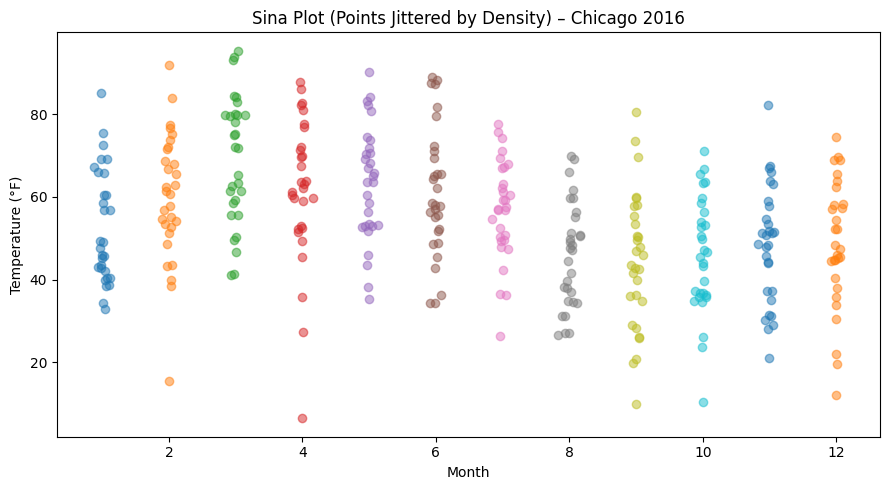

In [11]:
plt.figure(figsize=(9,5))
for i,m in enumerate(months):
    vals=df_chi[df_chi.Month==m].Temp
    # horizontal jitter proportional to local density
    density,grid=np.histogram(vals,bins=20)
    probs=density[np.digitize(vals,grid[:-1])-1]
    xjit=rng.normal(0,0.08*probs/probs.max(),len(vals))
    plt.scatter(np.full(len(vals),m)+xjit, vals, alpha=0.5)
plt.title("Sina Plot (Points Jittered by Density) – Chicago 2016")
plt.xlabel("Month"); plt.ylabel("Temperature (°F)")
plt.tight_layout(); plt.show()


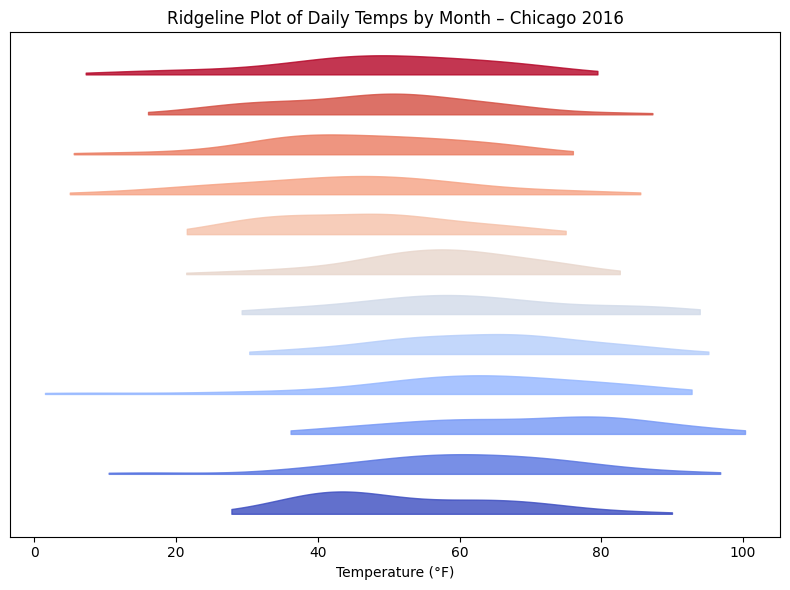

In [12]:
import matplotlib.cm as cm
plt.figure(figsize=(8,6))
colors=cm.coolwarm(np.linspace(0,1,12))
for i,m in enumerate(months):
    vals=df_chi[df_chi.Month==m].Temp
    kde_x=np.linspace(min(vals)-5,max(vals)+5,200)
    kde_y=stats.gaussian_kde(vals)(kde_x)
    plt.fill_between(kde_x, kde_y+i*0.05, i*0.05, color=colors[i], alpha=0.8)
plt.yticks([]); plt.xlabel("Temperature (°F)")
plt.title("Ridgeline Plot of Daily Temps by Month – Chicago 2016")
plt.tight_layout(); plt.show()


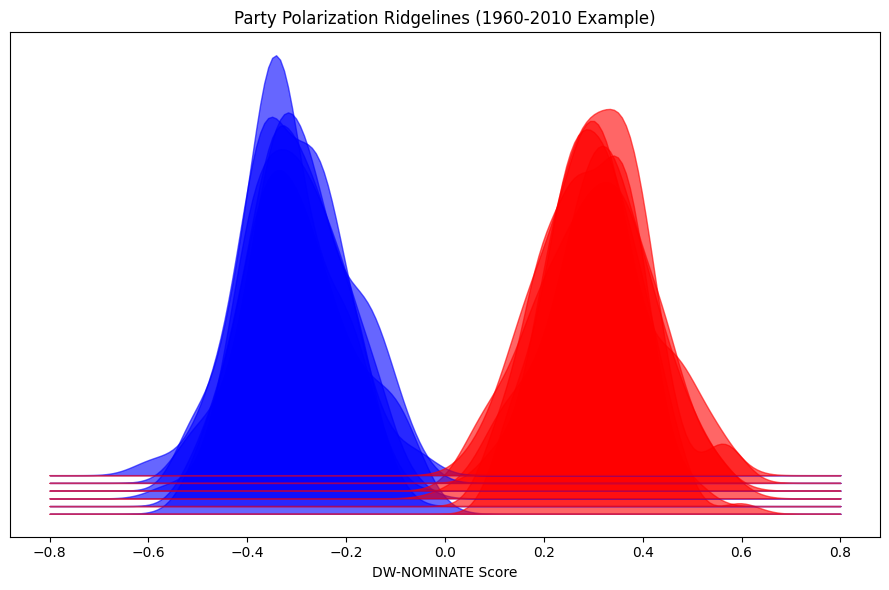

In [13]:
years=np.arange(1960,2020,10)
scores_dem=[rng.normal(-0.3,0.1,100) for _ in years]
scores_rep=[rng.normal( 0.3,0.1,100) for _ in years]

plt.figure(figsize=(9,6))
for i,yr in enumerate(years):
    for arr,color in zip([scores_dem[i],scores_rep[i]],['blue','red']):
        x=np.linspace(-0.8,0.8,200)
        y=stats.gaussian_kde(arr)(x)
        base=i*0.08
        plt.fill_between(x, y+base, base, color=color, alpha=0.6)
plt.xlabel("DW-NOMINATE Score"); plt.yticks([])
plt.title("Party Polarization Ridgelines (1960-2010 Example)")
plt.tight_layout(); plt.show()
